**Importing Libraries**

In [1]:
import pandas as pd
import numpy as np
import os
import pandas as pd
import cv2
import shutil
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Input, Dropout, Conv2D, Flatten, Lambda
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
import tensorflow as tf

**Loading Dataset**

In [2]:
df_train_new = pd.read_csv("df_train_csv.csv")
df_test_new = pd.read_csv("df_test_csv.csv")
df_valid_new = pd.read_csv("df_valid_csv.csv")

**Image Preprocessing**

In [9]:
datagen_train = ImageDataGenerator(rescale=1./255)
train_generator = datagen_train.flow_from_dataframe(df_train_new,
                                             directory = "C:/Users/Aaftab/Desktop/New folder/train/cropped",
                                             x_col = "filename",
                                             y_col = "class",
                                             target_size=(64,64),
                                             batch_size=64,
                                             class_mode='categorical',
                                             shuffle=True)

valid_generator = datagen_train.flow_from_dataframe(df_valid_new,
                                             directory = "C:/Users/Aaftab/Desktop/New folder/valid/cropped",
                                             x_col = "filename",
                                             y_col = "class",
                                             target_size=(64,64),
                                             batch_size=64,
                                             class_mode='categorical',
                                             shuffle=False)

datagen_test = ImageDataGenerator(rescale=1./255)
test_generator = datagen_test.flow_from_dataframe(df_test_new,
                                             directory = "C:/Users/Aaftab/Desktop/New folder/test/cropped",
                                             x_col = "filename",
                                             y_col = "class",
                                             target_size=(64,64),
                                             batch_size=128,
                                             class_mode='categorical',
                                             shuffle=False)

Found 14594 validated image filenames belonging to 11 classes.
Found 5064 validated image filenames belonging to 11 classes.


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\preprocessing\image.py:1137: UserWarning: Found 24379 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


Found 4848 validated image filenames belonging to 11 classes.


**Model Definition**

In [4]:
def Convolution(input_tensor, filters, kernel_size):
    x = Conv2D(filters=filters, kernel_size=kernel_size, padding="same")(input_tensor)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(0.25)(x)
    return x

def Dense_f(input_tensor, nodes):
    x = Dense(nodes)(input_tensor)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(0.25)(x)
    return x

def model_fer(input_shape):
    inputs = Input(input_shape)
    conv_1 = Convolution(inputs, 64, (3,3))
    conv_2 = Convolution(conv_1, 128, (5,5))
    conv_3 = Convolution(conv_2, 128, (3,3))
    flatten = Flatten()(conv_3)
    dense_1 = Dense_f(flatten, 64)
    
    output = Dense(11, activation="softmax")(dense_1)
    model = Model(inputs = [inputs], outputs = [output])
    opt = Adam(learning_rate=0.0001)
    model.compile(loss=["categorical_crossentropy"], optimizer = opt, metrics = ["accuracy"])
    return model

**Model Summary**

In [5]:
model = model_fer((64,64,3))
model.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 batch_normalization (Batch  (None, 64, 64, 64)        256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 64, 64, 64)        0         
                                                                 
 dropout (Dropout)           (None, 64, 64, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       204928    
                                                           

**Model Training**

In [6]:
checkpoint = ModelCheckpoint("model_weights_new.h5", monitor="val_accuracy", save_weights_only=True, mode="max", verbose=1)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=2, min_lr=0.00001)
callbacks = [checkpoint, reduce_lr]

In [7]:
history = model.fit(
x = train_generator,
steps_per_epoch = train_generator.n//train_generator.batch_size,
epochs = 20,
validation_data = valid_generator,
validation_steps = valid_generator.n//valid_generator.batch_size,
callbacks = callbacks)

Epoch 1/20


228/228 [==============================] - ETA: 0s - loss: 1.3862 - accuracy: 0.6398
Epoch 1: saving model to model_weights_new.h5
228/228 [==============================] - 455s 2s/step - loss: 1.3862 - accuracy: 0.6398 - val_loss: 1.7631 - val_accuracy: 0.6307 - lr: 1.0000e-04
Epoch 2/20
228/228 [==============================] - ETA: 0s - loss: 0.8764 - accuracy: 0.7745
Epoch 2: saving model to model_weights_new.h5
228/228 [==============================] - 465s 2s/step - loss: 0.8764 - accuracy: 0.7745 - val_loss: 1.5181 - val_accuracy: 0.6228 - lr: 1.0000e-04
Epoch 3/20
228/228 [==============================] - ETA: 0s - loss: 0.6714 - accuracy: 0.8251
Epoch 3: saving model to model_weights_new.h5
228/228 [==============================] - 458s 2s/step - loss: 0.6714 - accuracy: 0.8251 - val_loss: 1.1689 - val_accuracy: 0.6788 - lr: 1.0000e-04
Epoch 4/20
228/228 [==============================] - ETA: 0s - loss: 0.5844 - accuracy: 0.8396
Epoch 4: saving model to mode

**Model Evaluation**

In [10]:
model.evaluate(test_generator)

38/38 [==============================] - 32s 840ms/step - loss: 0.6301 - accuracy: 0.8129


[0.6300544142723083, 0.8129125237464905]

**Plotting Loss**

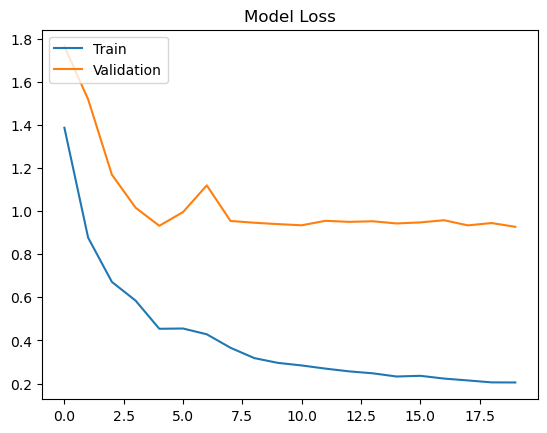

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss")
plt.legend(["Train","Validation"], loc="upper left")
#plt.subplots_adjust(top=1.0, bottom=0.0, right=0.95, left=0.0, hspace=0.25, wspace=0.35)

**Model Accuracy**

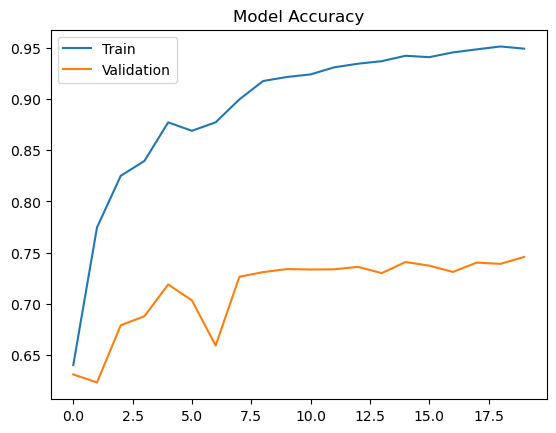

In [14]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model Accuracy")
plt.legend(["Train","Validation"], loc="upper left")
#plt.subplots_adjust(top=1.0, bottom=0.0, right=0.95, left=0.0, hspace=0.25, wspace=0.35)

**Saving Model**

In [20]:
model_json = model.to_json()
with open("model_a.json", "w") as file:
    file.write(model_json)
    print("Model saved.")

Model saved.
